In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from sklearn.model_selection import train_test_split
import shutil


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd 'gdrive/MyDrive/Colab Notebooks/Face Recognition/'

ModuleNotFoundError: No module named 'google.colab'

In [2]:
%pwd

'C:\\Users\\rumah\\Project\\Face Recognition'

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
TRAIN_PATH = 'Dataset/train/'
TEST_PATH = 'Dataset/test/'
IMG_SIZE = (218, 178)
BATCH_SIZE = 32
EPOCH_SIZE = 20


In [4]:
df_train = pd.read_csv('Dataset/list_train_clean.csv')
df_test = pd.read_csv('Dataset/list_test_clean.csv')

#df_train

In [5]:
df_train['Male'] = df_train['Male'].astype("string")
df_test['Male'] = df_test['Male'].astype("string")
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Filenames  4000 non-null   object
 1   Male       4000 non-null   string
dtypes: object(1), string(1)
memory usage: 62.6+ KB


In [6]:
df_train.loc[df_train['Male'] == '1', ['Male']] = 'Male'
df_train.loc[df_train['Male'] == '0', ['Male']] = 'Female'
df_train

,Filenames,Male
0,098446.jpg,Female
1,189077.jpg,Female
2,140986.jpg,Female
3,038818.jpg,Male
4,104595.jpg,Male
...,...,...
3995,093110.jpg,Female
3996,198880.jpg,Male
3997,013392.jpg,Male
3998,098793.jpg,Female


In [7]:
df_train['Male'].value_counts(normalize=True)*100

Male
Female    59.225
Male      40.775
Name: proportion, dtype: Float64

In [8]:
df_test['Male'].value_counts(normalize=True)*100

Male
0    58.4
1    41.6
Name: proportion, dtype: Float64

C:\Users\rumah\AppData\Local\Temp\ipykernel_5016\2761382631.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = row[0]


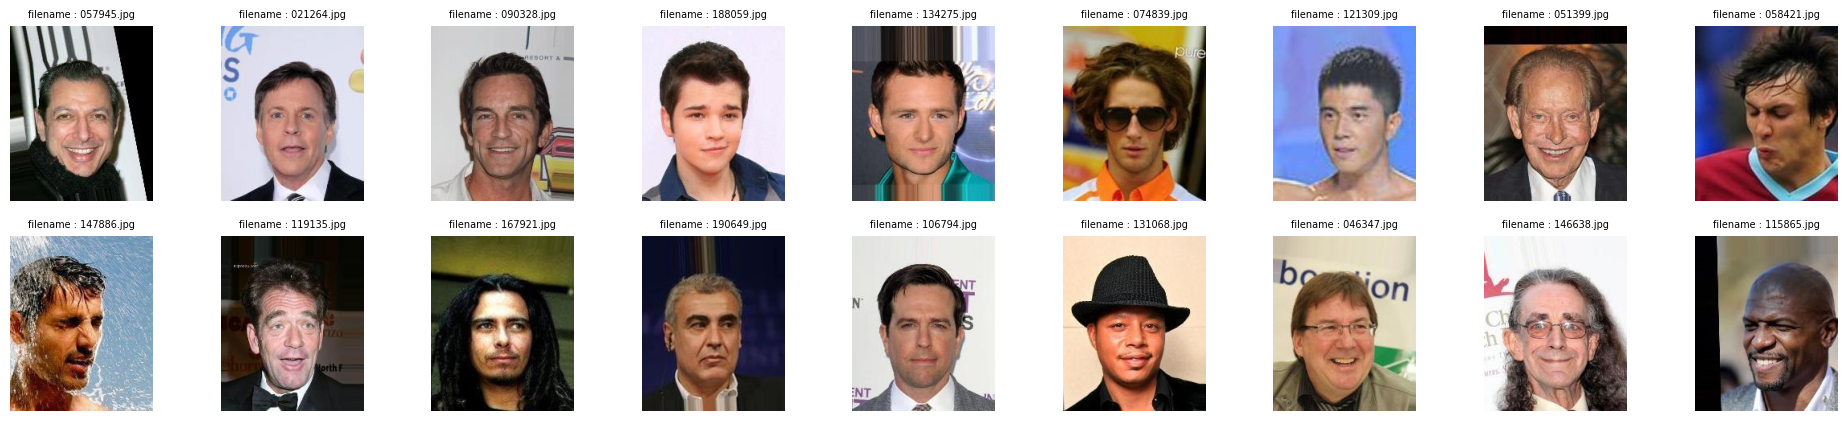

In [9]:
## Sampling random check for male images
x=0
fig = plt.figure(figsize = (24,5))
#for idx, row in df_train[['Filenames']].sample(n=18).iterrows() :
for idx, row in df_train.loc[df_train['Male'] == 'Male', ['Filenames']].sample(n=18).iterrows() :
  f = row[0]
  img_path = f'Dataset/train/{f}'
  #print(img_path)
  img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
  img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
  fig.add_subplot(2,9,x+1)
  plt.title(f'filename : {f}', fontsize = 7) 
  plt.axis('off')
  plt.imshow(img)
  x += 1

In [10]:
df_test.loc[df_test['Male'] == '1', ['Male']] = 'Male'
df_test.loc[df_test['Male'] == '0', ['Male']] = 'Female'
df_test

,Filenames,Male
0,122315.jpg,Male
1,153759.jpg,Male
2,115290.jpg,Male
3,157437.jpg,Female
4,192358.jpg,Female
...,...,...
995,144965.jpg,Female
996,026421.jpg,Male
997,151442.jpg,Female
998,012915.jpg,Female


C:\Users\rumah\AppData\Local\Temp\ipykernel_5016\3803919608.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = row[0]


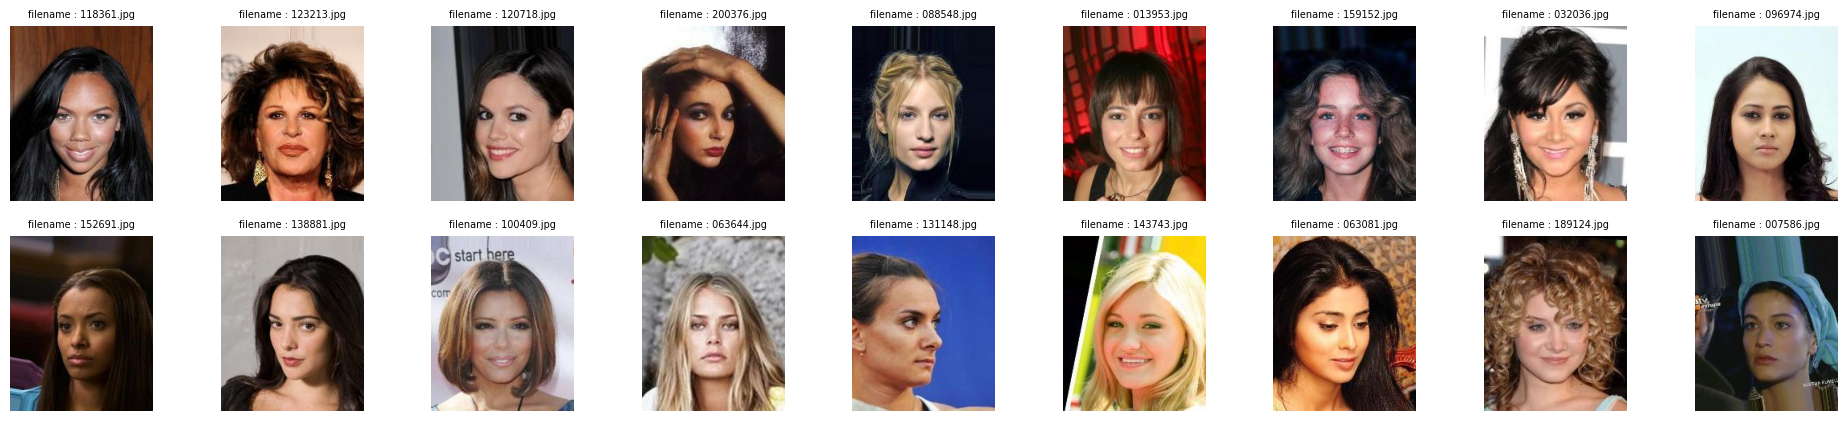

In [11]:
## Sampling random check for male images
x=0
fig = plt.figure(figsize = (24,5))
#for idx, row in df_train[['Filenames']].sample(n=18).iterrows() :
for idx, row in df_test.loc[df_test['Male'] == 'Female', ['Filenames']].sample(n=18).iterrows() :
  f = row[0]
  img_path = f'Dataset/test/{f}'
  #print(img_path)
  img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
  img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
  fig.add_subplot(2,9,x+1)
  plt.title(f'filename : {f}', fontsize = 7) 
  plt.axis('off')
  plt.imshow(img)
  x += 1

In [12]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    df_train,
    TRAIN_PATH,
    x_col='Filenames',
    y_col='Male',
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 4000 validated image filenames belonging to 2 classes.


In [13]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    df_test,
    TEST_PATH,
    x_col='Filenames',
    y_col='Male',
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 1000 validated image filenames belonging to 2 classes.


In [14]:
base_model16 = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape= IMG_SIZE + (3,))

In [24]:
base_model16.trainable = False
base_model16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 218, 178, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 218, 178, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 218, 178, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 109, 89, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 109, 89, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 109, 89, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 54, 44, 128)       0     

In [15]:
model = Sequential()
model.add(base_model16)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 5, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 15360)             0         
                                                                 
 dense (Dense)               (None, 256)               3932416   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 18647361 (71.13 MB)
Trainable params: 18647361 (71.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=4,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.001)
# Define a ModelCheckpoint callback to save the model weights during training
checkpoint_callback = ModelCheckpoint(filepath='Dataset/vgg16_weights_limitlayer.h5',
                                      save_best_only=True,
                                      save_weights_only=False)

callbacks = [checkpoint_callback, earlystop, learning_rate_reduction]


In [19]:
%%time
history = model.fit(train_generator,
                    validation_data = test_generator,
                    validation_steps=len(df_test)//BATCH_SIZE,
                    steps_per_epoch=len(df_train)//BATCH_SIZE,
                    epochs=30,
                    verbose = 1,
                    callbacks=callbacks
                    )

Epoch 1/30
125/125 [==============================] - ETA: 0s - loss: 0.8376 - accuracy: 0.5905 

C:\Project\Anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 4125s 33s/step - loss: 0.8376 - accuracy: 0.5905 - val_loss: 0.6804 - val_accuracy: 0.5827 - lr: 0.0010
Epoch 2/30
125/125 [==============================] - 4201s 34s/step - loss: 0.9408 - accuracy: 0.5847 - val_loss: 0.6803 - val_accuracy: 0.5827 - lr: 0.0010
Epoch 3/30
125/125 [==============================] - 4220s 34s/step - loss: 0.6773 - accuracy: 0.5922 - val_loss: 0.6796 - val_accuracy: 0.5827 - lr: 0.0010
Epoch 4/30
125/125 [==============================] - 4208s 34s/step - loss: 0.6765 - accuracy: 0.5922 - val_loss: 0.6787 - val_accuracy: 0.5847 - lr: 0.0010
Epoch 5/30
125/125 [==============================] - 4199s 34s/step - loss: 0.6761 - accuracy: 0.5922 - val_loss: 0.6785 - val_accuracy: 0.5857 - lr: 0.0010
Epoch 6/30
125/125 [==============================] - 4202s 34s/step - loss: 0.6761 - accuracy: 0.5922 - val_loss: 0.6796 - val_accuracy: 0.5827 - lr: 0.0010
Epoch 7/30
125/125 [==============================] - 4223s 34s

KeyboardInterrupt: 

In [20]:
np.save('training_history_vgg16limitlayer.npy', history.history)
model.save("model_finish_vgg16limitlayer.h5")

NameError: name 'history' is not defined

In [36]:
history_vgg19_ep20 = history

In [60]:
print(f"accuracy : {history_vgg19_ep20.history['accuracy'] [-1]}")
print(f"validation accuracy : {history_vgg19_ep20.history['val_accuracy'] [-1]}")

accuracy : 0.9200000166893005
validation accuracy : 0.8850806355476379


In [21]:
%%time
history2 = model.fit(train_generator,
                    validation_data = test_generator,
                    validation_steps=len(df_test)//BATCH_SIZE,
                    steps_per_epoch=len(df_train)//BATCH_SIZE,
                    epochs=10,
                    verbose = 1,
                    callbacks=callbacks
                    )

Epoch 1/10
125/125 [==============================] - 1878s 15s/step - loss: 0.1707 - accuracy: 0.9300 - val_loss: 0.1964 - val_accuracy: 0.9214 - lr: 0.0010
Epoch 2/10
125/125 [==============================] - 1879s 15s/step - loss: 0.1640 - accuracy: 0.9333 - val_loss: 0.2216 - val_accuracy: 0.9183 - lr: 0.0010
Epoch 3/10
125/125 [==============================] - 1877s 15s/step - loss: 0.1638 - accuracy: 0.9327 - val_loss: 0.1869 - val_accuracy: 0.9254 - lr: 0.0010
Epoch 4/10
125/125 [==============================] - 1874s 15s/step - loss: 0.1494 - accuracy: 0.9395 - val_loss: 0.2069 - val_accuracy: 0.9244 - lr: 0.0010
Epoch 5/10
125/125 [==============================] - 1874s 15s/step - loss: 0.1611 - accuracy: 0.9312 - val_loss: 0.2034 - val_accuracy: 0.9224 - lr: 0.0010
Epoch 6/10
125/125 [==============================] - 1878s 15s/step - loss: 0.1609 - accuracy: 0.9342 - val_loss: 0.2802 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 7/10
125/125 [==============================] 

In [22]:
np.save('training_history2.npy', history.history)
model.save("model_finish2.h5")

In [37]:
np.save('training_history2_vgg19_ep30.npy', history2.history)
history_vgg19_ep30 = history2

In [23]:
base_model16 = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape= IMG_SIZE + (3,))

58889256/58889256 [==============================] - 4s 0us/step


In [24]:
base_model16.trainable = False
base_model16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 218, 178, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 218, 178, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 218, 178, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 109, 89, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 109, 89, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 109, 89, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 54, 44, 128)       0     

In [25]:
model2 = Sequential()
model2.add(base_model16)
model2.add(Flatten())
model2.add(Dense(256,activation='relu'))
model2.add(Dense(256,activation='relu'))
model2.add(Dense(64,activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(2, activation='sigmoid'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 5, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 15360)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               3932416   
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dense_8 (Dense)             (None, 64)                16448     
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 32)               

In [26]:
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=4,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.001)
# Define a ModelCheckpoint callback to save the model weights during training
checkpoint_callback = ModelCheckpoint(filepath='Dataset/vgg_weights16.h5',
                                      save_best_only=True,
                                      save_weights_only=False)

In [28]:
callbacks = [checkpoint_callback, earlystop, learning_rate_reduction]

In [29]:
%%time
history3 = model2.fit(train_generator,
                    validation_data = test_generator,
                    validation_steps=len(df_test)//BATCH_SIZE,
                    steps_per_epoch=len(df_train)//BATCH_SIZE,
                    epochs=EPOCH_SIZE,
                    verbose = 1,
                    callbacks=callbacks
                    )

Epoch 1/20
125/125 [==============================] - 1485s 12s/step - loss: 0.3794 - accuracy: 0.8267 - val_loss: 0.2581 - val_accuracy: 0.8952 - lr: 0.0010
Epoch 2/20
125/125 [==============================] - 1483s 12s/step - loss: 0.2658 - accuracy: 0.8928 - val_loss: 0.2221 - val_accuracy: 0.9143 - lr: 0.0010
Epoch 3/20
125/125 [==============================] - 1486s 12s/step - loss: 0.2438 - accuracy: 0.8982 - val_loss: 0.2213 - val_accuracy: 0.9093 - lr: 0.0010
Epoch 4/20
125/125 [==============================] - 1487s 12s/step - loss: 0.2302 - accuracy: 0.9035 - val_loss: 0.1891 - val_accuracy: 0.9274 - lr: 0.0010
Epoch 5/20
125/125 [==============================] - 1491s 12s/step - loss: 0.1985 - accuracy: 0.9193 - val_loss: 0.2123 - val_accuracy: 0.9204 - lr: 0.0010
Epoch 6/20
125/125 [==============================] - 1495s 12s/step - loss: 0.1899 - accuracy: 0.9220 - val_loss: 0.1955 - val_accuracy: 0.9143 - lr: 0.0010
Epoch 7/20
125/125 [==============================] 

In [30]:
np.save('training_history2.npy', history2.history)

In [31]:
np.save('training_history3.npy', history3.history)
model2.save("model_finishvgg16_20.h5")

In [38]:
np.save('training_history_vgg16_ep20.npy', history3.history)
history_vgg16_ep20 = history3

In [32]:
%%time
history4 = model2.fit(train_generator,
                    validation_data = test_generator,
                    validation_steps=len(df_test)//BATCH_SIZE,
                    steps_per_epoch=len(df_train)//BATCH_SIZE,
                    epochs=10,
                    verbose = 1,
                    callbacks=callbacks
                    )

Epoch 1/10
125/125 [==============================] - 1511s 12s/step - loss: 0.1389 - accuracy: 0.9430 - val_loss: 0.1914 - val_accuracy: 0.9244 - lr: 0.0010
Epoch 2/10
125/125 [==============================] - 1513s 12s/step - loss: 0.1189 - accuracy: 0.9482 - val_loss: 0.1636 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 3/10
125/125 [==============================] - 1516s 12s/step - loss: 0.1335 - accuracy: 0.9450 - val_loss: 0.1613 - val_accuracy: 0.9385 - lr: 0.0010
Epoch 4/10
125/125 [==============================] - 1516s 12s/step - loss: 0.1433 - accuracy: 0.9417 - val_loss: 0.1795 - val_accuracy: 0.9395 - lr: 0.0010
Epoch 5/10
125/125 [==============================] - 1515s 12s/step - loss: 0.1271 - accuracy: 0.9532 - val_loss: 0.1880 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 6/10
125/125 [==============================] - 1519s 12s/step - loss: 0.1180 - accuracy: 0.9538 - val_loss: 0.1815 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 7/10
125/125 [==============================] 

In [33]:
np.save('training_history4.npy', history4.history)
model2.save("model_finishvgg16_30.h5")

In [39]:
np.save('training_history_vgg16_ep30.npy', history4.history)
history_vgg16_ep30 = history4

In [46]:
def plot_history(history, title):
    ## accuracy
    plt.figure(figsize=(18, 4))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()
    plt.title(f'Accuracy {title}')
    #plt.title('Model Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

    # loss function 
    plt.figure(figsize=(18, 4))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='valid')
    plt.legend()
    plt.title(f'Loss {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

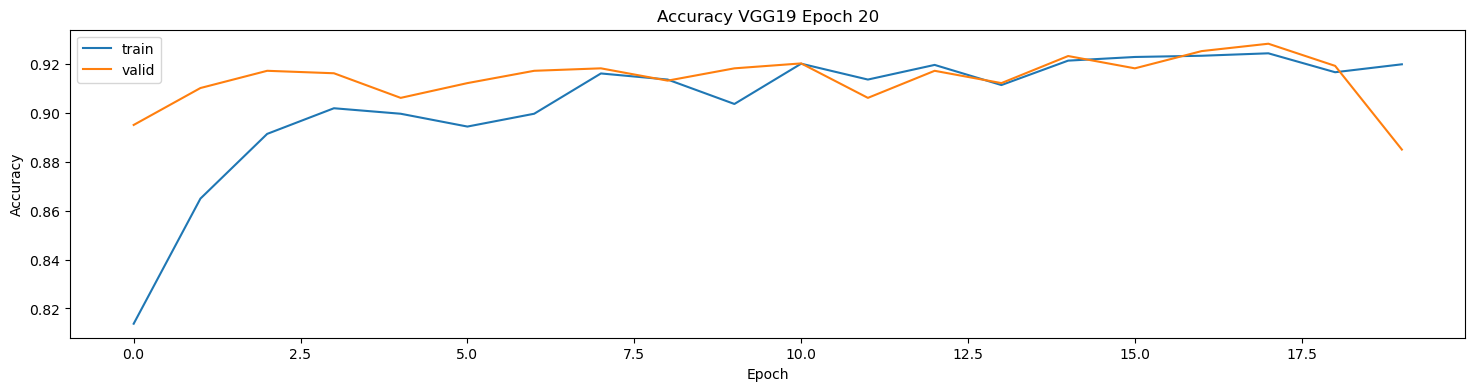

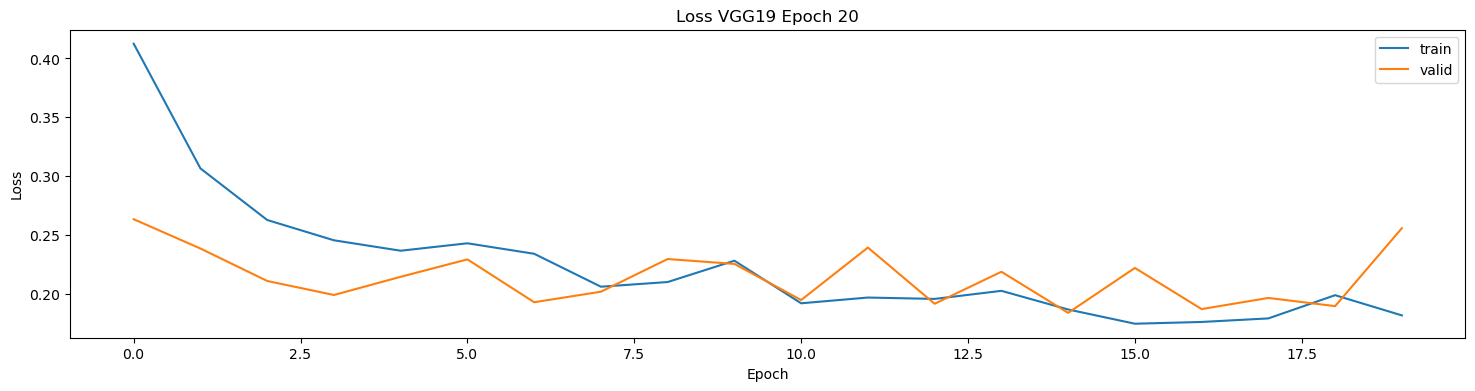

In [48]:
plot_history(history_vgg19_ep20, 'VGG19 Epoch 20')

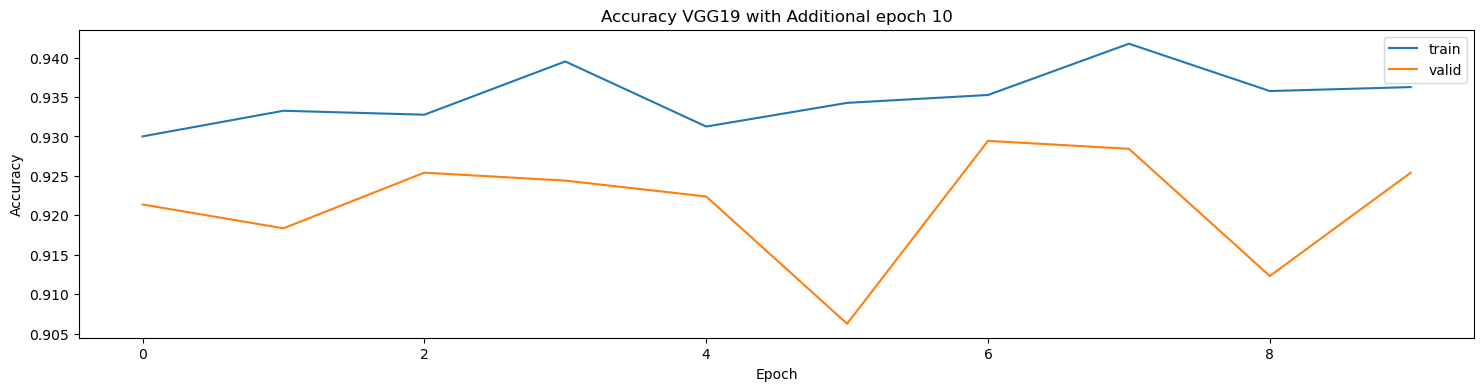

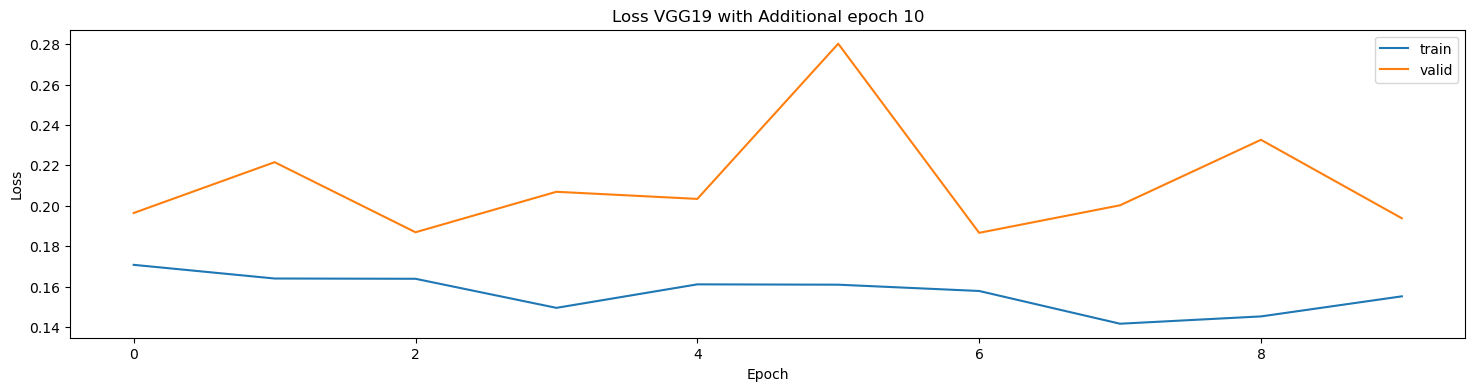

In [49]:
plot_history(history_vgg19_ep30, 'VGG19 with Additional epoch 10')

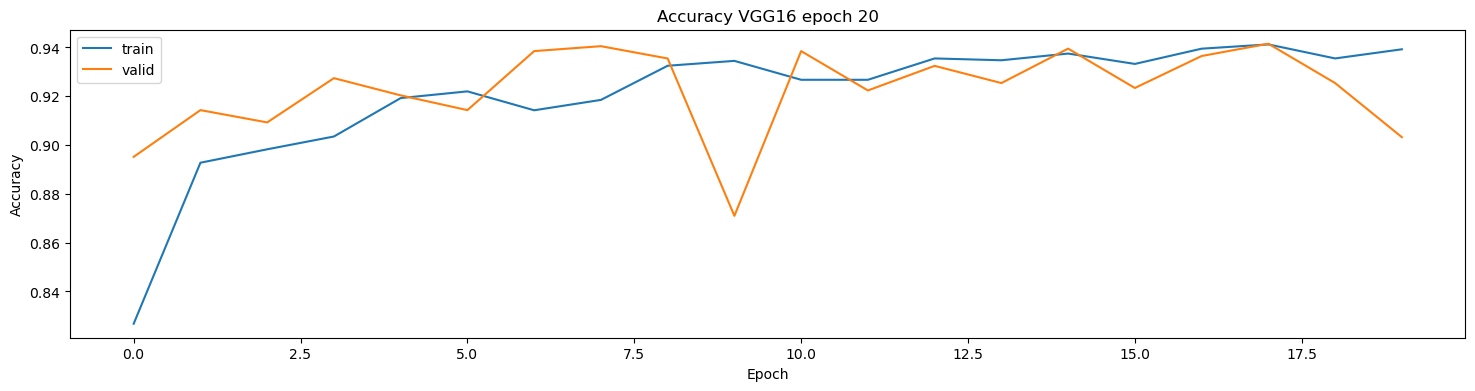

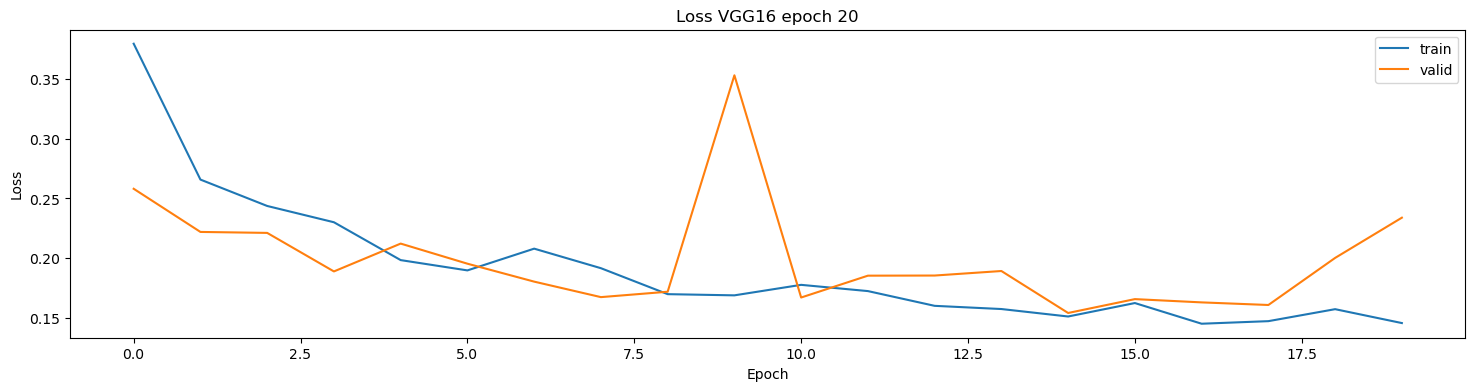

In [50]:
plot_history(history_vgg16_ep20, 'VGG16 epoch 20')

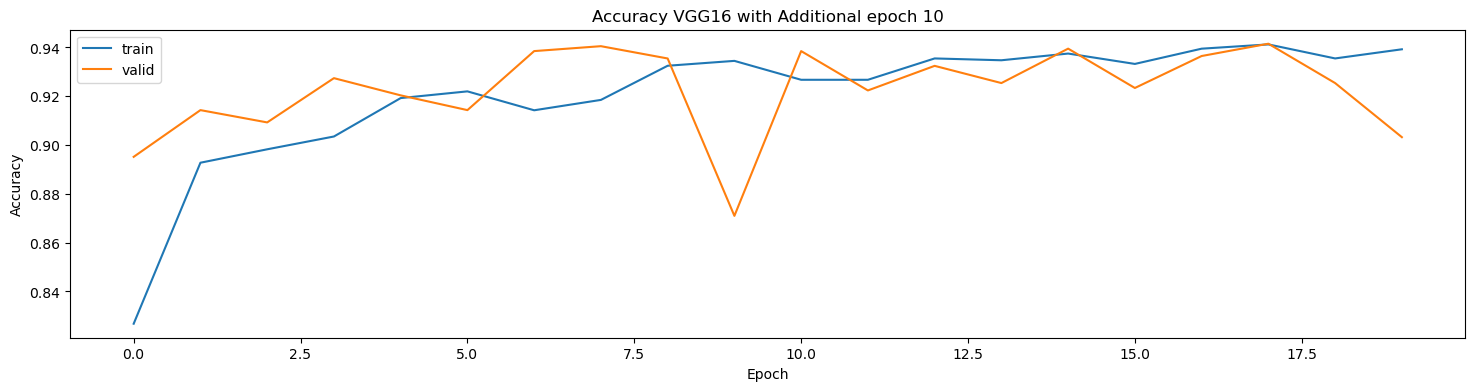

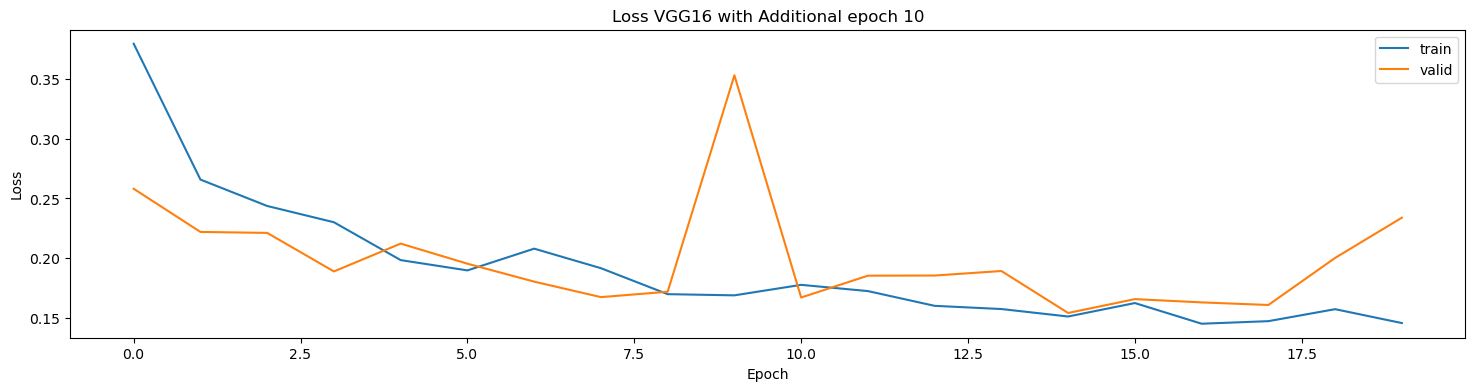

In [51]:
plot_history(history_vgg16_ep20, 'VGG16 with Additional epoch 10')

In [ ]:
testing_datagen = ImageDataGenerator(rescale=1./255)
testing_generator = testing_datagen.flow_from_dataframe(
    df_test,
    TEST_PATH,
    x_col='Filenames',
    y_col=None,
    target_size=IMG_SIZE,
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [66]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from sklearn.metrics import confusion_matrix,accuracy_score

def show_confusion_matrix(model) :
    # Evaluate the model on the validation set
    evaluation = model.evaluate(testing_generator)
    # Print the evaluation results
    print(f"Validation Loss: {evaluation[0]}")
    print(f"Validation Accuracy: {evaluation[1]}")
    
    # Plot the confusion matrix
    predict = model.predict(test_generator)
    predictions = predict.argmax(axis=1)
    predictions_map = ["Male" if v == 1 else "Female" for v in predictions]

    conf_matrix = confusion_matrix(df_test['Male'], predictions_map, labels = labels)

df_predict = pd.DataFrame({'label': true_labels, 'predict':binary_predictions})
df_predict.loc[df_predict['label'] != df_predict['predict'], ['label','predict']]
binary_predictions_map = ["Male" if v == 1 else "Female" for v in binary_predictions]

accuracy = accuracy_score(df_test['Male'], binary_predictions_map)
accuracy
    
    true_labels = test_generator.classes
    
    binary_prediction = predictions.argmax(axis=-1)
    #binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]
    conf_matrix = confusion_matrix(true_labels, binary_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',
    xticklabels=['Predicted Negative', 'Predicted Positive'],
    yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


In [142]:
vgg16_ep20_model = tf.keras.models.load_model("model_finish.h5")

In [143]:
vgg16_ep20_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 6, 5, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 15360)             0         
                                                                 
 dense (Dense)               (None, 256)               3932416   
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 32)                1

In [68]:
show_confusion_matrix(vgg16_ep20_model)

32/32 [==============================] - 351s 11s/step - loss: 0.2567 - accuracy: 0.8830
Validation Loss: 0.25671032071113586
Validation Accuracy: 0.8830000162124634


NameError: name 'predict' is not defined

32/32 [==============================] - 330s 10s/step - loss: 0.1936 - accuracy: 0.9250
Validation Loss: 0.1936499923467636
Validation Accuracy: 0.925000011920929
32/32 [==============================] - 381s 12s/step


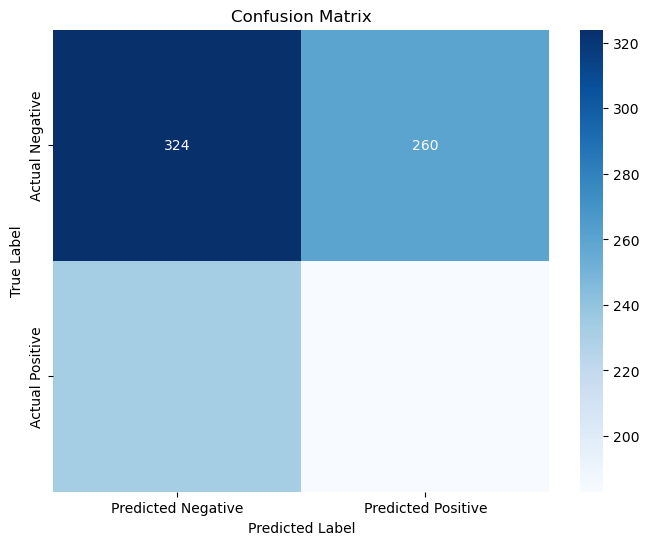

In [69]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from sklearn.metrics import confusion_matrix,accuracy_score

# Evaluate the model on the validation set
evaluation = model.evaluate(test_generator)
# Print the evaluation results
print(f"Validation Loss: {evaluation[0]}")
print(f"Validation Accuracy: {evaluation[1]}")
# Plot the confusion matrix




true_labels = test_generator.classes
predictions = model.predict(test_generator)
binary_predictions = predictions.argmax(axis=-1)
#binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]
conf_matrix = confusion_matrix(true_labels, binary_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',
 xticklabels=['Predicted Negative', 'Predicted Positive'],
 yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [150]:
testing_datagen = ImageDataGenerator(rescale=1./255)
testing_generator = testing_datagen.flow_from_dataframe(
    df_test,
    TEST_PATH,
    x_col='Filenames',
    y_col=None,
    target_size=IMG_SIZE,
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 1000 validated image filenames.


32/32 [==============================] - 330s 10s/step


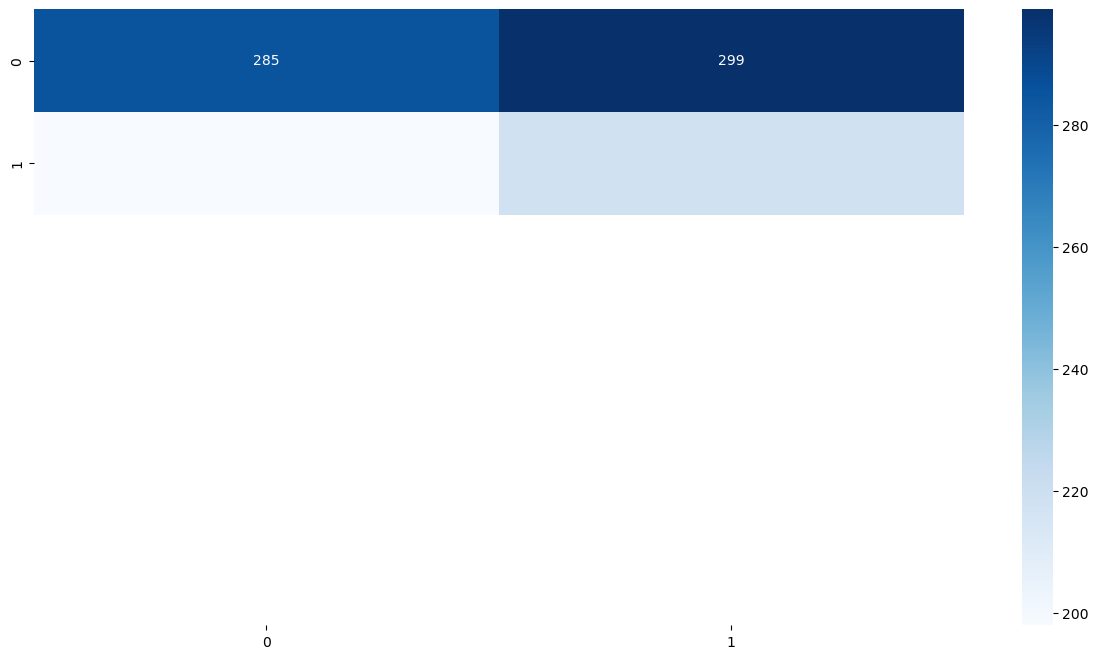

In [152]:
import seaborn as sns
#true_labels = testing_generator.classes
predictions = vgg16_ep20_model.predict(testing_generator)
binary_predictions = predictions.argmax(axis=-1)

#binary_predictions = predictions.argmax(axis=-1)
#binary_predictions_map = ["Male" if v == 1 else "Female" for v in binary_predictions]
labels = ['Male','Female']
#conf_matrix = confusion_matrix(df_test['Male'], binary_predictions_map, labels = labels)
#conf_matrix = confusion_matrix(true_labels, binary_predictions)

plt.figure(figsize=(15, 8))
#conf_matrix = [[23,  5],
#               [ 3, 30]]
ax = sns.heatmap(conf_matrix, annot=True,fmt='g', cmap='Blues')
#xticklabels=['Predicted Negative', 'Predicted Positive'],
#yticklabels=['Actual Negative', 'Actual Positive'])
#plt.title('Confusion Matrix')
#plt.xlabel('Predicted Label')
#plt.ylabel('True Label')
#bottom, top = ax.get_ylim()
#ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_ylim(6.0 , 0)
plt.show()
#ax.get_ylim()


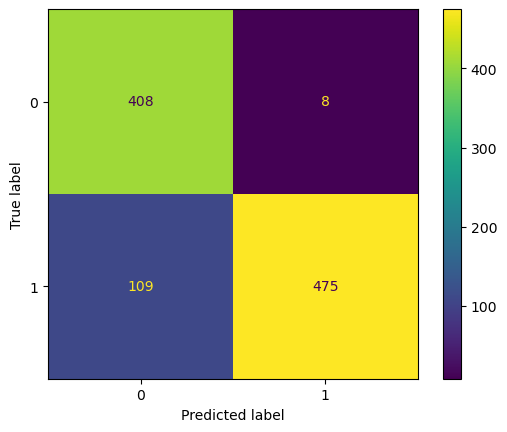

In [156]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()

In [159]:
from sklearn.metrics import accuracy_score
binary_predictions = predictions.argmax(axis=1)
df_predict = pd.DataFrame({'label': true_labels, 'predict':binary_predictions})
df_predict.loc[df_predict['label'] != df_predict['predict'], ['label','predict']]
binary_predictions_map = ["Male" if v == 1 else "Female" for v in binary_predictions]

accuracy = accuracy_score(df_test['Male'], binary_predictions_map)
accuracy
#df_predict['result'] = 

0.883

In [154]:
conf_matrix = confusion_matrix(df_test['Male'], binary_predictions_map, labels = labels)

In [155]:
conf_matrix

array([[408,   8],
       [109, 475]], dtype=int64)

NameError: name 'ticker' is not defined

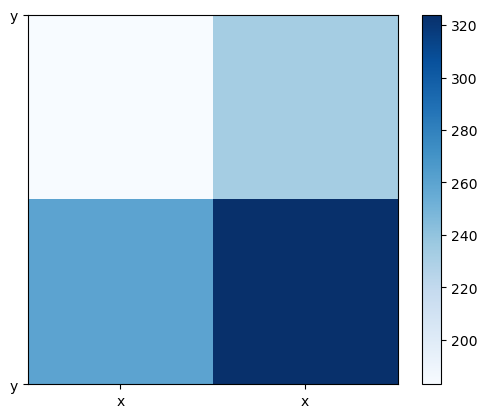

In [103]:
fig, ax = plt.subplots()
cm = confusion_matrix(df_test['Male'], binary_predictions_map, labels = labels)

im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(yticks=[-0.5, 1.5], 
       xticks=[0, 1], 
       yticklabels='yy', 
       xticklabels='xx')
# ax.yaxis.set_major_locator(ticker.IndexLocater(base=1, offset=0.5))
# should change to 
ax.yaxis.set_major_locator(ticker.IndexLocator(base=1, offset=0.5))

In [82]:
test_generator.classes

[1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,


In [ ]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(true_labels, predictions)
average_precision = average_precision_score(true_labels, predictions)
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve (AP={0:.2f})'.format(average_precision))
plt.show()